# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
from keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Importing Dataset and Plotting Images

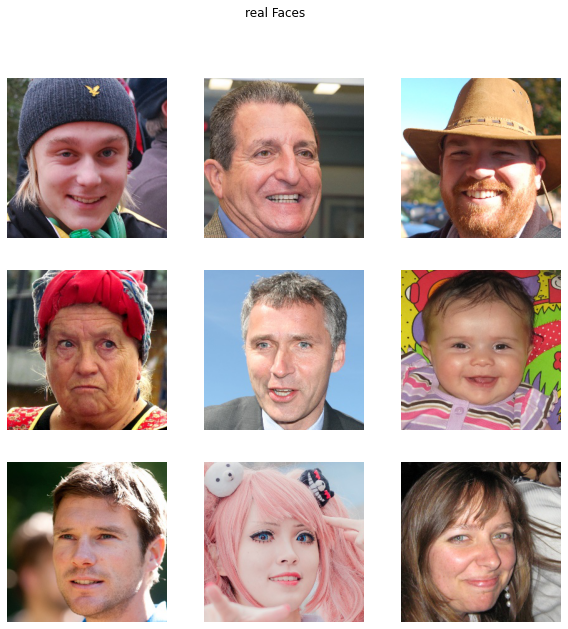

In [2]:
path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

### Fake Set

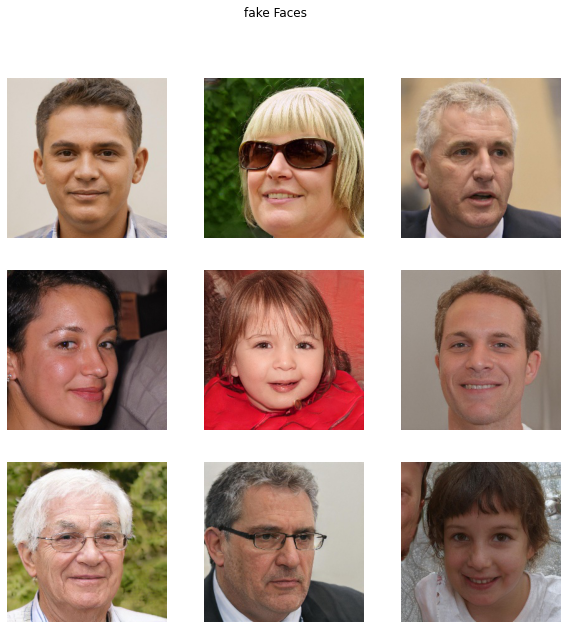

In [3]:
plot_img(path, 'fake').show()

# Train and Validation Set 

In [42]:
bs = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

# Creating Model
I tried Different model architecture like VGG, mobilenet but DenseNet works best

In [43]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 7,564,865
Trainable params: 7,480,193
Non-trainable params: 84,672
_______________________________________

### Defining Model Checkpoints

In [18]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4
                   )

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

# Accuracy On test set

In [ ]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

# Confusion Matrix and Classification Report

In [ ]:
y_pred = spoofnet.predict(test_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=names))

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)

In [5]:
 !pwd

/kaggle/working


In [6]:
import os
os.listdir('/kaggle/working')

['__notebook_source__.ipynb']

In [24]:
cd /kaggle/working

/kaggle/working


In [44]:
spoofnet = load_model('../input/real-vs-fake-faces/spoffnet.h5')

In [45]:
spoofnet.layers[0]

In [46]:
base_model = spoofnet.layers[0]

In [47]:
base_model.trainable = True

In [48]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  427


In [49]:
for layer in base_model.layers[:400]:
    layer.trainable = False

In [50]:
spoofnet.compile(optimizer=Adam(lr=0.1*0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

In [51]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4
                   )

Epoch 1/4
1562/1562 [==============================] - 926s 593ms/step - loss: 0.0533 - accuracy: 0.9799 - val_loss: 0.0465 - val_accuracy: 0.9832
Epoch 2/4
1562/1562 [==============================] - 463s 296ms/step - loss: 0.0364 - accuracy: 0.9867 - val_loss: 0.0423 - val_accuracy: 0.9840
Epoch 3/4
1562/1562 [==============================] - 482s 309ms/step - loss: 0.0326 - accuracy: 0.9880 - val_loss: 0.0405 - val_accuracy: 0.9853
Epoch 4/4
1562/1562 [==============================] - 480s 307ms/step - loss: 0.0303 - accuracy: 0.9889 - val_loss: 0.0400 - val_accuracy: 0.9848


In [52]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 208s 665ms/step - loss: 0.0395 - accuracy: 0.9860
Final Test Acccuracy = 98.600


In [56]:
spoofnet.save('./style-gan/')

In [58]:
import shutil
shutil.make_archive('stylegans', 'zip', './style-gan')

'/kaggle/working/stylegans.zip'